# **Captcha recognition using CRNN with CTC Loss**
## Overview
This project demonstrates a deep learning-based approach for text recognition in images using a Convolutional Recurrent Neural Network (CRNN) with Connectionist Temporal Classification (CTC) loss. The model is designed to efficiently recognize sequences of text in images by leveraging both convolutional and recurrent architectures.

## Model Architecture
The CRNN is a hybrid model combining Convolutional Neural Networks (CNNs) for feature extraction and Recurrent Neural Networks (RNNs) for sequence modeling. This makes it particularly well-suited for tasks like text recognition, where spatial and sequential dependencies are important. The key components of the model are:

**Convolutional Layers:** 
These layers extract essential visual features from the input images, such as edges and patterns, making it easier for the model to identify characters.

**Recurrent Layers (LSTM):**
Bidirectional Long Short-Term Memory (LSTM) layers process the extracted features in a sequential manner, capturing dependencies across time steps to recognize text sequences effectively.

**Output Layer:**
The final layer applies a softmax activation function to predict character probabilities, forming the recognized text sequence.

**CTC Loss:**
The Connectionist Temporal Classification (CTC) loss function enables the model to handle variable-length text sequences without requiring pre-segmented character labels, making it ideal for OCR tasks.
This architecture provides a robust solution for text recognition in images, allowing for accurate sequence predictions without explicit character alignment.

In [ ]:
import numpy as np
from pathlib import Path
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
import zipfile
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode

# **Upload of the Dataset**
Select any Dataset locally on wich you want to train the Modell.

In [ ]:
uploaded = files.upload()
# Extrahiere die hochgeladene ZIP-Datei
for file_name in uploaded.keys():
    if file_name.endswith(".zip"):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall("/content")
        print(f"{file_name} wurde extrahiert!")

Saving ImgCaptchaAriel.zip to ImgCaptchaAriel.zip
ImgCaptchaAriel.zip wurde extrahiert!


# **Extraction Dataset**
This extracts the images from a Zip Folder with the following structure:

ZipFolder/

│── Folder/

│   ├── image1.jpg

│   ├── image2.jpg

│   ├── ...

In [ ]:
for file_name in uploaded.keys():
    if file_name.endswith(".zip"):
        extraction_path = f"/content/{file_name.replace('.zip', '')}_extracted"

        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            # Print first few file names to understand structure
            print("First 10 files in ZIP:", zip_ref.namelist()[:10])

            # Extract all files, preserving directory structure
            zip_ref.extractall(extraction_path)

        # Find all JPG files recursively
        image_paths = list(Path(extraction_path).rglob("*.jpg"))

        print(f"Extracted to: {extraction_path}")
        print("Number of images found:", len(image_paths))
        print("First few image paths:", image_paths[:5])

# If images found, update your image directory
if image_paths:
    image_dir = Path(extraction_path)

Extracted to: /content/ImgCaptchaAriel_extracted
Extracted files: [PosixPath('/content/ImgCaptchaAriel_extracted/ImgCaptchaAriel')]
Number of images: 0
First few image paths: []


In [9]:
# Define constants
image_height, image_width = 70, 250
batch_size = 32

# Directory containing captcha images
image_dir = Path('/content/ImgCaptchaAriel_extracted/ImgCaptchaAriel')

# Create a list of image file paths and corresponding labels
image_paths = [str(image) for image in sorted(Path(image_dir).glob("*.jpg"))]
labels = [image.stem for image in sorted(Path(image_dir).glob("*.jpg"))]

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


# Create a set of all unique characters in the labels
all_possible_characters = sorted(set("".join(labels)))

# Create a mapping of characters to integers and integers to characters
char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
int_to_char = {i: char for char, i in char_to_int.items()}


# Define a function to preprocess an image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, (image_height, image_width))

    # Kontrast erhöhen
    image = tf.image.adjust_contrast(image, 5.0)  # Kontrastfaktor anpassbar

    # Threshold anwenden
    #threshold = 0.5
    #image = tf.cast(image > threshold, tf.float32)

    return image

# Preprocess images and labels
images = [preprocess_image(image_path) for image_path in image_paths]
encoded_labels = [[char_to_int[char] for char in label] for label in labels]

# Create TensorFlow Datasets
dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels))

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(images))

# Split the dataset into training and validation sets (adjust as needed)
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = dataset.skip(train_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)



## Random Sample Visualization

This section of the code is designed to visualize random samples from the dataset to help assess how well the model is learning.

1. **Iterator Creation**: The function begins by creating an iterator for the dataset, which allows sequential access to the data during visualization.

2. **Random Sample Selection**: The function iterates through the dataset to select a specified number of random samples (`num_samples`). In this case, the default is set to 5 samples, but this can be adjusted as needed.

3. **Label Decoding**: For each selected sample, the corresponding label (which is in the form of integers) is decoded back into its character representation using the `int_to_char` mapping. This converts the numerical labels into readable text.

4. **Image Display**: Each image is displayed using Matplotlib, where the grayscale image is shown with a specified size and a label is shown as the title. The label is the decoded text representing the captcha in the image.

5. **Plotting**: For each random sample, the image is plotted, and the label is shown above it, giving a visual understanding of the dataset and how well the OCR model is recognizing characters.

This function is useful for visually inspecting how the dataset looks, checking label accuracy, and debugging any potential issues with the data pipeline or preprocessing steps.


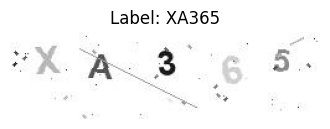

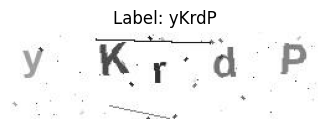

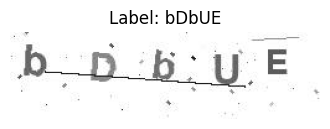

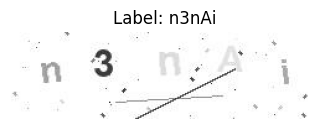

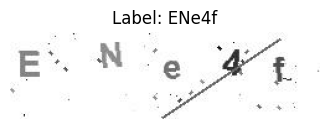

In [10]:
def visualize_random_samples(dataset, int_to_char, num_samples=5):
    """
    Visualize random samples from a dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Iterate through the random samples and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)

        # Decode the label (convert integers to characters)
        label = [int_to_char[int(x)] for x in label[0].numpy()]

        # Display the image and label
        plt.figure(figsize=(4, 2))
        plt.imshow(image[0, :, :, 0], cmap='grey')
        plt.title("Label: " + ''.join(label))
        plt.axis('off')
        plt.show()

# Example usage:
visualize_random_samples(validation_dataset, int_to_char, num_samples=5)

## Model Architecture Definition

In this section, the code defines the architecture of an Optical Character Recognition (OCR) model using a combination of convolutional, recurrent, and dense layers.

1. **Input Layer**: 
   - The model begins by defining the input layer, where the input shape is set to `(image_height, image_width, 1)` to accommodate grayscale captcha images.

2. **Standardization**: 
   - The input data is standardized to fall within the [0, 1] range using the `Rescaling` layer, which is essential for normalizing pixel values before feeding them into the model.

3. **Transpose Layer**: 
   - A `Lambda` layer is used to transpose the input tensor. This changes the shape to `(None, image_width, image_height, 1)`, altering the ordering of the dimensions to better suit the subsequent layers.

4. **Convolutional Layers**: 
   - The model includes multiple convolutional layers with the `ReLU` activation function and `he_normal` kernel initialization. These layers are used to extract features from the images:
     - The first convolutional layer has 64 filters, followed by a max pooling operation.
     - The second convolutional layer, again with 64 filters, is followed by another max pooling operation.
     - The third convolutional layer has 128 filters and is followed by max pooling over the time dimension.

5. **Reshaping**: 
   - After the convolutional layers, the output is reshaped to accommodate the reduced number of channels. The shape is modified to `(image_width // 8, (image_height // 4) * 128)` to prepare it for the recurrent layers.

6. **Dense Layer**: 
   - A dense layer with 128 units and `ReLU` activation is added to further process the extracted features. A dropout layer with a rate of 0.3 is applied to help prevent overfitting.

7. **Recurrent Layer**: 
   - A bidirectional LSTM layer with 128 units is added. The bidirectional nature allows the model to capture information from both the past and future, crucial for sequence prediction tasks like OCR.

8. **Output Layer**: 
   - The output layer consists of a dense layer with `softmax` activation. The number of units is equal to the size of the character set plus one (for the CTC "blank" token), allowing the model to predict one character at a time.

9. **Model Compilation**: 
   - A custom CTC loss function is defined using `ctc_batch_cost`. The model is compiled with the Adam optimizer and the CTC loss function.
   - The learning rate for the optimizer is set to 0.1, though this can be adjusted.

10. **Model Summary**: 
    - Finally, the model summary is printed to provide a detailed view of the architecture, including the number of parameters in each layer.

This section is essential for setting up the OCR model, which uses convolutional layers for feature extraction, recurrent layers for sequence prediction, and a custom CTC loss function to train the model on captcha recognition.


In [ ]:
# Define the input layer
input_data = Input(shape=(image_height, image_width, 1), name='input_image')

# Standardize values to be in the [0, 1] range
x = Rescaling(1./255)(input_data)

# Transpose the tensor to shape (None, image_width, image_height, 1)
x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

# Convolutional layers - Reduzierte Channel (32, 64, 128 statt 64, 128, 256)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = MaxPooling2D((2, 2), name="pool1")(x)

x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

x = Conv2D(128, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = MaxPooling2D((2, 1), name="pool3")(x) # Pooling over time dimension

# Reshape anpassen wegen der reduzierten Channel im letzten Conv2D Layer (128 statt 256)
x = Reshape(target_shape=(image_width // 8, (image_height // 4) * 128), name="reshape")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = Dropout(0.7)(x)

# Recurrent layers (Bidirectional LSTM)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)

# Output layer (CTC)
output = Dense(len(all_possible_characters) + 1, activation='softmax')(x)

# Create the model
model = Model(inputs=input_data, outputs=output, name="OCR_model")

# Model kompilieren mit angepasster Loss Function
def ctc_loss(labels, logits):
    label_length = tf.cast(tf.fill((tf.shape(labels)[0], 1), max_length), dtype='int64')
    logit_length = tf.cast(tf.fill((tf.shape(logits)[0], 1), tf.shape(logits)[1]), dtype='int64')
    return tf.reduce_mean(ctc_batch_cost(labels, logits, logit_length, label_length))
    
optimizer = Adam(learning_rate=0.1) # you can adjust learning rate here
model.compile(optimizer=Adam(), loss=ctc_loss)

model.summary()

Model: "OCR_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 70, 250, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 70, 250, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transpose (Lambda)                   │ (None, 250, 70, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 250, 70, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 125, 35, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 35, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 62, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 62, 17, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 31, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 31, 2176)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 31, 128)             │         278,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 31, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 31, 45)              │          11,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,813 (2.54 MB)

 Trainable params: 664,813 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

This section focuses on training the OCR model with the defined datasets and callbacks.

1. **Epochs Definition**: 
   - The training is set to run for a total of 100 epochs, meaning the model will iterate over the entire training dataset 100 times during training.

2. **Callbacks**: 
   - **Early Stopping**: An `EarlyStopping` callback is defined to monitor the training loss. The model will stop training if the loss does not improve for 20 consecutive epochs (`patience=20`). This helps prevent overfitting and unnecessary computation. Additionally, the best weights (the weights with the lowest loss) will be restored after training is stopped.

3. **Model Training**: 
   - The model is trained using the `fit()` method with the following settings:
     - `train_dataset`: The dataset used for training the model.
     - `epochs`: The number of epochs for which the model will be trained (100 epochs).
     - `validation_data`: The dataset used for validating the model's performance during training.
     - `callbacks`: The list of callbacks (in this case, EarlyStopping) that are applied during training to monitor progress and adjust behavior if necessary.

This section ensures that the model trains efficiently and doesn't overfit by monitoring the loss and adjusting the training process through the EarlyStopping callback.


In [45]:
num_epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=20,
        verbose=1,
        restore_best_weights=True),
]

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - loss: 30.0500 - val_loss: 21.0108
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 20.7301 - val_loss: 20.8103
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 20.6892 - val_loss: 20.7704
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 20.6538 - val_loss: 20.6990
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 20.6524 - val_loss: 20.6750
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 20.6261 - val_loss: 20.6276
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 20.6480 - val_loss: 20.6776
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 20.6105 - val_loss: 20.5853
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 20.5979 - val_loss: 20.5822
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 20.5622 - val_loss: 20.5205
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 20.5408 - val_loss: 20.4504
Epoch 12/100
62/62 ━━━━━━━━━

## Training History Visualization

In this section, the training history of the model is visualized to assess how well the model performed during the training process.

1. **Find the Best Epoch**: 
   - The epoch with the lowest validation loss is determined by finding the index of the minimum value in the validation loss history (`history.history['val_loss']`). This helps identify when the model performed best on the validation dataset.

2. **Plotting the Loss**: 
   - The function `plot_training_history` is defined to create a plot of the training and validation losses over the epochs. The following steps are involved:
     - **Plotting Loss**: Both the training loss (`history.history['loss']`) and validation loss (`history.history['val_loss']`) are plotted on the same graph, with labels indicating which curve corresponds to which dataset.
     - **Plot Customization**: The plot is customized with labels for the x-axis (Epoch) and y-axis (Loss), along with a title ("Model Loss").
     - **Annotating Best Epoch**: The epoch with the lowest validation loss is annotated on the plot. The annotation includes the value of the lowest validation loss and the epoch number, making it easy to pinpoint where the model performed best.

3. **Displaying the Plot**: 
   - The plot is displayed using `plt.show()`, which visualizes the training and validation losses along with the best epoch.

This section helps monitor the model's performance during training, allowing for a quick assessment of how well the model is generalizing to the validation dataset, and it identifies the best epoch based on validation loss.


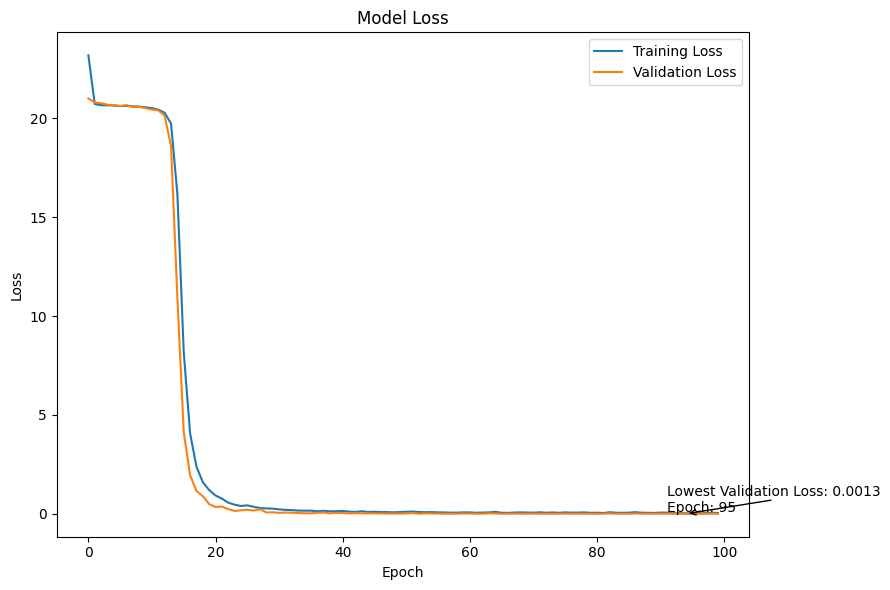

In [46]:
# Find the epoch with the lowest validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))


# Plot training history without accuracy
def plot_training_history(history, best_epoch):
    plt.figure(figsize=(9, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Display the lowest validation loss and the epoch at which it occurred
    min_val_loss = min(history.history['val_loss'])
    plt.annotate(
        f'Lowest Validation Loss: {min_val_loss:.4f}\nEpoch: {best_epoch + 1}',
        xy=(best_epoch, min_val_loss),
        xytext=(best_epoch - 3, min_val_loss + 0.1),  # Adjust text position
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    plt.tight_layout()
    plt.show()


plot_training_history(history, best_epoch)

## Decode and Visualize Model Predictions

This section focuses on visualizing the model's predictions for random samples from the dataset, allowing us to evaluate how well the model decodes captcha images.

1. **Iterator Creation**: 
   - An iterator is created for the dataset to access batches of images and their corresponding labels during visualization.

2. **Subplot Creation**: 
   - A grid of subplots is created to display multiple samples at once. The number of rows in the grid corresponds to the number of samples to be visualized (default is 5).

3. **Prediction and Decoding**: 
   - For each sample, the following steps are performed:
     - **Model Prediction**: The model predicts the labels for the input images.
     - **CTC Decoding**: The predictions are decoded using the CTC (Connectionist Temporal Classification) decode function, which outputs the decoded characters. The dynamic sequence length is calculated based on the prediction shape.
     - **Filtering Decoded Labels**: The decoded labels are converted from integers to characters using the `int_to_char` mapping. Any `-1` values (representing blanks) are filtered out, ensuring only valid characters are included.

4. **Displaying Images and Predictions**: 
   - The image is displayed using `imshow`, and the decoded text is shown as the title of the corresponding subplot. This allows for a side-by-side comparison of the image and the model’s prediction.

5. **Layout Adjustment**: 
   - The `tight_layout()` function is called to ensure that the subplots are well spaced and readable. Finally, the plot is displayed using `plt.show()`.

This section helps in visually evaluating the model's performance by displaying the captcha images alongside their predicted text, offering insights into how well the OCR model is recognizing characters.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


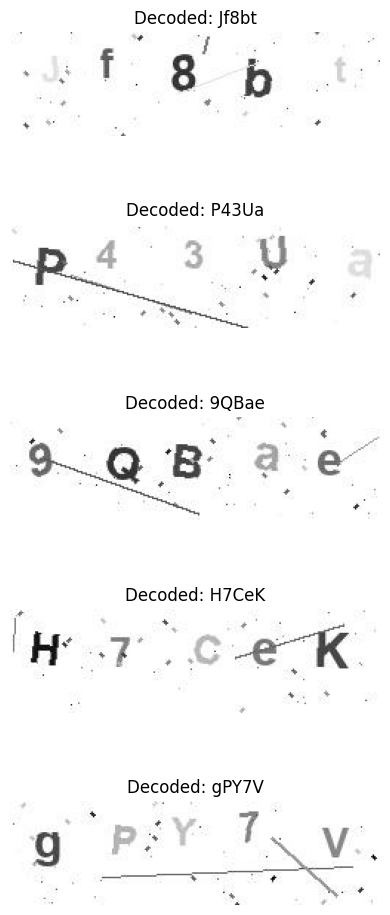

In [47]:
def decode_and_visualize_samples(model, dataset, int_to_char, num_samples=5):
    """
    Decode and visualize random samples from a dataset using the provided model.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """
    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Create a subplot grid
    fig, axes = plt.subplots(num_samples, 1, figsize=(4, 2 * num_samples))

    # Iterate through the random samples, decode, and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)

        # Make predictions using the model
        predictions = model.predict(image)

        # Decode the predictions using CTC decode
        input_length = tf.fill((predictions.shape[0],), predictions.shape[1])  # Dynamische Länge
        decoded, _ = ctc_decode(predictions, input_length=input_length, greedy=True)

        # Convert decoded labels to characters with filtering
        decoded_labels = [
            int_to_char.get(int(x), '')  # Ersetze -1 durch '', falls vorhanden
            for x in decoded[0][0, :].numpy()  # Greife auf die decodierten Werte zu
            if x != -1  # Filtere -1 aus
        ]
        decoded_text = ''.join(decoded_labels).strip()  # Zusammensetzen des Texts

        # Display the image and decoded label
        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Decoded: " + decoded_text)
        axes[i].axis('off')

    # Adjust spacing and display the grid
    plt.tight_layout()
    plt.show()

# Example usage:
decode_and_visualize_samples(model, validation_dataset, int_to_char, num_samples=5)



# **Upload of the testset**
Select any Dataset locally on wich you want to train the Modell.

In [21]:
uploaded = files.upload()
# Extrahiere die hochgeladene ZIP-Datei
for file_name in uploaded.keys():
    if file_name.endswith(".zip"):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall("/content")
        print(f"{file_name} wurde extrahiert!")

Saving ImgCaptchaArieltest.zip to ImgCaptchaArieltest.zip
ImgCaptchaArieltest.zip wurde extrahiert!


# **Extraction of the testset**
This extracts the images from a Zip Folder with the following structure:

ZipFolder/

│── Folder/

│   ├── image1.jpg

│   ├── image2.jpg

│   ├── ...



In [ ]:
for file_name in uploaded.keys():
    if file_name.endswith(".zip"):
        extraction_path = f"/content/{file_name.replace('.zip', '')}_extracted"

        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            # Print first few file names to understand structure
            print("First 10 files in ZIP:", zip_ref.namelist()[:10])

            # Extract all files, preserving directory structure
            zip_ref.extractall(extraction_path)

        # Find all JPG files recursively
        image_paths = list(Path(extraction_path).rglob("*.jpg"))

        print(f"Extracted to: {extraction_path}")
        print("Number of images found:", len(image_paths))
        print("First few image paths:", image_paths[:5])

# If images found, update your image directory
if image_paths:
    image_dir = Path(extraction_path)

First 10 files in ZIP: ['ImgCaptchaArieltest/', 'ImgCaptchaArieltest/24TW9.jpg', 'ImgCaptchaArieltest/25H3g.jpg', 'ImgCaptchaArieltest/2B3mM.jpg', 'ImgCaptchaArieltest/2K4y4.jpg', 'ImgCaptchaArieltest/2Nnk9.jpg', 'ImgCaptchaArieltest/2TF3i.jpg', 'ImgCaptchaArieltest/2UYTn.jpg', 'ImgCaptchaArieltest/2yyE7.jpg', 'ImgCaptchaArieltest/38eTg.jpg']
Extracted to: /content/ImgCaptchaArieltest_extracted
Number of images found: 250
First few image paths: [PosixPath('/content/ImgCaptchaArieltest_extracted/ImgCaptchaArieltest/ta6HA.jpg'), PosixPath('/content/ImgCaptchaArieltest_extracted/ImgCaptchaArieltest/AnMti.jpg'), PosixPath('/content/ImgCaptchaArieltest_extracted/ImgCaptchaArieltest/YQiTa.jpg'), PosixPath('/content/ImgCaptchaArieltest_extracted/ImgCaptchaArieltest/Hdg56.jpg'), PosixPath('/content/ImgCaptchaArieltest_extracted/ImgCaptchaArieltest/RNAi9.jpg')]


# **Preprocessing the testset**
The preprocessing is identical to the preprocessing of the training data.

In [26]:
# Define constants
image_height, image_width = 70, 250
batch_size = 32

# Directory containing captcha images
image_dir = Path('/content/ImgCaptchaArieltest_extracted/ImgCaptchaArieltest')

# Create a list of image file paths and corresponding labels
image_paths = [str(image) for image in sorted(Path(image_dir).glob("*.jpg"))]
labels = [image.stem for image in sorted(Path(image_dir).glob("*.jpg"))]

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Create a set of all unique characters in the labels
all_possible_characters = sorted(set("".join(labels)))

# Create a mapping of characters to integers and integers to characters
char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
int_to_char = {i: char for char, i in char_to_int.items()}


# Define a function to preprocess an image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, (image_height, image_width))

    # Increase contrast
    image = tf.image.adjust_contrast(image, 5.0)

    return image

# Preprocess images and labels
images = [preprocess_image(image_path) for image_path in image_paths]
encoded_labels = [[char_to_int[char] for char in label] for label in labels]

# Create TensorFlow Datasets
dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels))

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(images))
# Split the dataset into training and validation sets (adjust as needed)
test_size = int(len(image_paths))
test_dataset = dataset.take(test_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


## Model Accuracy Evaluation

This section calculates the accuracy of the OCR model by comparing the predicted text with the actual labels from the test dataset.

1. **Accuracy Calculation**:
   - The function `accuracy()` iterates through the entire test dataset, making predictions on each image and comparing those predictions to the ground truth labels.
   
2. **Predictions and Decoding**:
   - For each image in the dataset, the model's predictions are made using `model.predict(image)`. 
   - The predictions are decoded using CTC decode (`ctc_decode`) to obtain the predicted text from the model's output. This function converts the model's raw output into readable text by considering dynamic sequence lengths.
   
3. **Label and Prediction Comparison**:
   - Both the true labels (from the dataset) and the decoded predictions are converted to text using the `int_to_char` mapping.
   - For each image, the true label and predicted label are printed for visual inspection. The labels are compared, and "Correct" or "Incorrect" is printed depending on whether the prediction matches the actual label.

4. **Accuracy Metrics**:
   - If the predicted label matches the true label, a counter (`correct`) is incremented. The total number of samples is also tracked.
   - After processing the entire dataset, the overall accuracy is calculated as the percentage of correct predictions out of the total samples.

5. **Results**:
   - The total number of samples, the number of correct predictions, and the calculated accuracy percentage are printed for the user's reference.

This section provides a detailed evaluation of the model's performance on the test dataset, offering insights into how well the model is generalizing and performing on unseen data.


In [51]:
def accuracy(dataset, int_to_char):
    correct = 0
    total = 0
    # Iterate through entire dataset
    for image, label in dataset:
        # Make predictions using the model
        predictions = model.predict(image)

        # Decode the predictions using CTC decode
        input_length = tf.fill((predictions.shape[0],), predictions.shape[1])
        decoded, *_ = ctc_decode(predictions, input_length=input_length, greedy=True)

        # Convert labels and predictions to text
        for i in range(len(label)):
            # Decode label
            true_label = [int_to_char[int(x)] for x in label[i].numpy()]
            true_text = ''.join(true_label)

            # Decode prediction
            decoded_labels = [
                int_to_char.get(int(x), '')
                for x in decoded[0][i, :].numpy()
                if x != -1
            ]
            decoded_text = ''.join(decoded_labels).strip()

            # Print both actual and predicted labels
            print(f"Actual Label: {true_text}")
            print(f"Predicted Label: {decoded_text}")
            print("Correct" if true_text == decoded_text else "Incorrect")
            print("---")

            # Check accuracy
            if true_text == decoded_text:
                correct += 1
            total += 1

    # Calculate overall accuracy
    accuracy_percentage = (correct * 100) / total
    print(f"Total Samples: {total}")
    print(f"Correct Predictions: {correct}")
    print(f"Accuracy: {accuracy_percentage:.2f}%")
    return accuracy_percentage

accuracy(test_dataset, int_to_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Actual Label: XEVkJ
Predicted Label: XEVkJ
Correct
---
Actual Label: 9BFQD
Predicted Label: 9BFQD
Correct
---
Actual Label: 5U9QJ
Predicted Label: 5U9QJ
Correct
---
Actual Label: hPMyV
Predicted Label: YPMyV
Incorrect
---
Actual Label: UBNHW
Predicted Label: UBNHW
Correct
---
Actual Label: CJF5F
Predicted Label: CJF5F
Correct
---
Actual Label: kXy9V
Predicted Label: kXy8V
Incorrect
---
Actual Label: 5XbVD
Predicted Label: 5XbVD
Correct
---
Actual Label: 9EJgb
Predicted Label: 9EJgb
Correct
---
Actual Label: 38eTg
Predicted Label: 38eTg
Correct
---
Actual Label: PY2Re
Predicted Label: PY2Re
Correct
---
Actual Label: 562ya
Predicted Label: 562ya
Correct
---
Actual Label: AmYB8
Predicted Label: AmYB8
Correct
---
Actual Label: NEkbt
Predicted Label: YEkbt
Incorrect
---
Actual Label: qB59J
Predicted Label: qB59J
Correct
---
Actual Label: yhgD4
Predicted Label: yhgD4
Correct
---
Actual Label: HrtNe
Predicted Label: HrtNe
Correct
---
Actual Label: bUQ9i
P

94.4

ohne lower und uppercase


## Model Accuracy Evaluation 
Accuracy of the Modell Without the Case sensitivity. Works the same as above.

In [49]:
def accuracy(dataset, int_to_char):
    correct = 0
    total = 0
    # Iterate through entire dataset
    for image, label in dataset:
        # Make predictions using the model
        predictions = model.predict(image)

        # Decode the predictions using CTC decode
        input_length = tf.fill((predictions.shape[0],), predictions.shape[1])
        decoded, *_ = ctc_decode(predictions, input_length=input_length, greedy=True)

        # Convert labels and predictions to text
        for i in range(len(label)):
            # Decode label
            true_label = [int_to_char[int(x)] for x in label[i].numpy()]
            true_text = ''.join(true_label).lower()  # Convert to lowercase

            # Decode prediction
            decoded_labels = [
                int_to_char.get(int(x), '')
                for x in decoded[0][i, :].numpy()
                if x != -1
            ]
            decoded_text = ''.join(decoded_labels).strip().lower()  # Convert to lowercase

            # Print both actual and predicted labels
            print(f"Actual Label: {true_text}")
            print(f"Predicted Label: {decoded_text}")
            print("Correct" if true_text == decoded_text else "Incorrect")
            print("---")

            # Check accuracy
            if true_text == decoded_text:
                correct += 1
            total += 1

    # Calculate overall accuracy
    accuracy_percentage = (correct * 100) / total
    print(f"Total Samples: {total}")
    print(f"Correct Predictions: {correct}")
    print(f"Accuracy: {accuracy_percentage:.2f}%")
    return accuracy_percentage

accuracy(test_dataset, int_to_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Actual Label: dtpmt
Predicted Label: dtpmt
Correct
---
Actual Label: n7drv
Predicted Label: n7drv
Correct
---
Actual Label: tedm7
Predicted Label: tedm7
Correct
---
Actual Label: ywtea
Predicted Label: ywtea
Correct
---
Actual Label: 4h6h3
Predicted Label: 4n6n3
Incorrect
---
Actual Label: hblbe
Predicted Label: hblbe
Correct
---
Actual Label: tu489
Predicted Label: tu489
Correct
---
Actual Label: 7bmnt
Predicted Label: 7bmnt
Correct
---
Actual Label: n7qnt
Predicted Label: n7qnt
Correct
---
Actual Label: fn5kg
Predicted Label: fn5kg
Correct
---
Actual Label: qrdkf
Predicted Label: qrdkf
Correct
---
Actual Label: vm3ty
Predicted Label: vm3ty
Correct
---
Actual Label: fnbyt
Predicted Label: fnbyt
Correct
---
Actual Label: bgetk
Predicted Label: bgetk
Correct
---
Actual Label: db6bk
Predicted Label: db6bk
Correct
---
Actual Label: ytkvb
Predicted Label: ytkvb
Correct
---
Actual Label: gah5q
Predicted Label: gah5q
Correct
---
Actual Label: 8hwnr
Predi

92.4